In [77]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics 

In [78]:
df=pd.read_csv('treated_BC5.csv')

In [79]:
df.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price
0,1,33,35,77,150,2016-12-27,1.0,495.0
1,1,33,313,657,2,2018-06-21,1.0,655.0
2,1,33,313,657,2,2018-08-08,1.0,655.0
3,1,33,313,657,2,2018-08-23,1.0,655.0
4,1,33,313,657,2,2018-10-07,1.0,655.0


In [80]:
#df.shape
#df.info()

In [81]:
df['Date'] =pd.to_datetime(df['Date'])

df['Quarter']=pd.PeriodIndex(df.Date, freq='Q')
df

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4
1,1,33,313,657,2,2018-06-21,1.0,655.0,2018Q2
2,1,33,313,657,2,2018-08-08,1.0,655.0,2018Q3
3,1,33,313,657,2,2018-08-23,1.0,655.0,2018Q3
4,1,33,313,657,2,2018-10-07,1.0,655.0,2018Q4
...,...,...,...,...,...,...,...,...,...
75980062,21,170,719,2498,407,2017-07-27,1.0,2345.0,2017Q3
75980063,21,170,719,2498,410,2016-07-12,1.0,2230.0,2016Q3
75980064,21,170,719,2498,410,2016-07-21,1.0,2230.0,2016Q3
75980065,21,170,719,2498,410,2017-10-31,1.0,11610.0,2017Q4


In [82]:
#### methods used to evaluate the clusters

In [83]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=2, ncols=len(label_columns), figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=axes[0, 0])
        sns.barplot(x=label, y="counts", data=counts, ax=axes[1, 0])

        # Setting Layout
        handles, _ = axes[0, 0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        axes[0, 0].annotate(titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        axes[0, 0].legend(handles, cluster_labels) # Adaptable to number of clusters
        axes[0, 0].axhline(color="black", linestyle="--")
        axes[0, 0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=20)
        axes[0, 0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        axes[1, 0].set_xticklabels(cluster_labels)
        axes[1 ,0].set_xlabel("")
        axes[1, 0].set_ylabel("Absolute Frequency")
        axes[1, 0].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=20)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [84]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

In [90]:
##### CLUSTERING - PREFERENCES PERSPECTIVE

In [91]:
# create a new dataframe with number of units of a each family of products for each pos
df_ = pd.DataFrame(df.groupby(['Point-of-Sale_ID', 'ProductFamily_ID'])['Unit'].sum().unstack(fill_value=0))

In [92]:
df_
df_final_not_norm=df_
df_final_not_norm

ProductFamily_ID,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,94398.0,28944.0,12091.0,436.0,2842.0,6138.0,1865.0,9316.0,105672.0,4024.0,...,63212.0,1235.0,21110.0,19742.0,4665.0,378.0,23065.0,466.0,316.0,34716.0
2,77916.0,32978.0,8814.0,212.0,2256.0,4652.0,2741.0,8900.0,92484.0,2506.0,...,60267.0,1101.0,22136.0,19383.0,4647.0,59.0,18588.0,251.0,250.0,20687.0
3,110754.0,48688.0,14323.0,536.0,3393.0,10249.0,3182.0,11153.0,152604.0,2572.0,...,89747.0,1228.0,25660.0,26229.0,6729.0,187.0,27282.0,456.0,329.0,41373.0
4,115017.0,38398.0,11761.0,617.0,3646.0,7058.0,2014.0,10517.0,171198.0,3773.0,...,140198.0,1933.0,26054.0,33588.0,5840.0,563.0,29617.0,883.0,1898.0,83589.0
5,66385.0,33506.0,8505.0,705.0,3136.0,4552.0,1853.0,8703.0,125447.0,2660.0,...,84937.0,1225.0,33983.0,25513.0,7014.0,303.0,20211.0,531.0,632.0,39029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,99340.0,41714.0,7892.0,272.0,4352.0,5697.0,2373.0,12587.0,83951.0,3494.0,...,77927.0,2898.0,35053.0,23473.0,6882.0,176.0,19695.0,543.0,690.0,41443.0
407,134946.0,46477.0,8017.0,609.0,3564.0,4886.0,3637.0,11314.0,120628.0,4503.0,...,106977.0,2809.0,29716.0,31296.0,10913.0,236.0,26788.0,619.0,1206.0,59642.0
408,86044.0,35552.0,6742.0,669.0,3107.0,3252.0,2152.0,8872.0,66279.0,2930.0,...,69281.0,2694.0,27543.0,22081.0,8981.0,45.0,23481.0,498.0,270.0,33224.0


In [93]:
#df_pref_all=df_final_not_norm

In [94]:
metric=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21]

In [95]:
##### scaling data with MinMax Scaler
df_final=df_final_not_norm.copy()
df_scaled = MinMaxScaler().fit_transform(df_final[metric])
df_final[metric]=df_scaled
df_final

ProductFamily_ID,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Point-of-Sale_ID,,,,,,,,,,,,,,,,,,,,,
1,0.407454,0.369579,0.746692,0.208157,0.125609,0.312366,0.151181,0.302431,0.389453,0.316171,...,0.255514,0.125037,0.157418,0.240926,0.267494,0.129947,0.411779,0.103687,0.032050,0.185947
2,0.317126,0.441690,0.518457,0.089513,0.088016,0.223766,0.251663,0.279338,0.320910,0.175093,...,0.234807,0.105091,0.175957,0.230949,0.266157,0.018214,0.305117,0.044081,0.023345,0.100875
3,0.497093,0.722516,0.902145,0.261123,0.160957,0.557477,0.302248,0.404408,0.633374,0.181227,...,0.442087,0.123995,0.239633,0.421211,0.420814,0.063047,0.512246,0.100915,0.033764,0.226315
4,0.520456,0.538576,0.723708,0.304025,0.177188,0.367219,0.168273,0.369102,0.730014,0.292844,...,0.796819,0.228937,0.246752,0.625730,0.354776,0.194746,0.567875,0.219296,0.240702,0.482314
5,0.253931,0.451128,0.496936,0.350636,0.144470,0.217803,0.149805,0.268402,0.492230,0.189405,...,0.408267,0.123549,0.390022,0.401312,0.441985,0.103678,0.343784,0.121708,0.073727,0.212101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.434539,0.597851,0.454242,0.121292,0.222479,0.286072,0.209452,0.484012,0.276561,0.266914,...,0.358979,0.372581,0.409356,0.344617,0.432179,0.059194,0.331491,0.125035,0.081377,0.226740
407,0.629676,0.682993,0.462947,0.299788,0.171927,0.237718,0.354439,0.413345,0.467184,0.360688,...,0.563235,0.359333,0.312921,0.562031,0.731615,0.080210,0.500476,0.146105,0.149433,0.337099
408,0.361671,0.487702,0.374147,0.331568,0.142610,0.140293,0.184102,0.277784,0.184714,0.214498,...,0.298187,0.342215,0.273657,0.305931,0.588100,0.013310,0.421690,0.112559,0.025983,0.176900


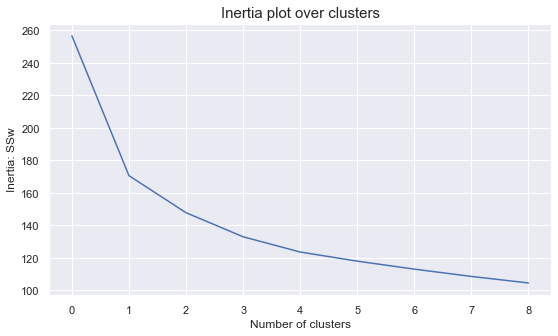

In [96]:
#### TRYING WITH KMEANS
### KMEANS 
# To decide how many clusters to use in the clustering we will use the elbow method
range_clusters = range(1, 10)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_final[metric])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution


plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [97]:
# Final Kmeans clustering solution
number_clusters = 4
kmeans = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
kmeans_labels

# Characterizing the final clusters
df_concat = pd.concat((df_final, pd.Series(kmeans_labels.astype(int), name='kmeans labels')), axis=1)
df_centroids = df_concat.groupby('kmeans labels').mean()
df_centroids

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
kmeans labels,,,,,,,,,,,,,,,,,,,,,
0.0,0.306854,0.447662,0.342680,0.248018,0.274504,0.364996,0.305105,0.421547,0.400412,0.301932,...,0.429359,0.283364,0.291925,0.404645,0.308482,0.166989,0.449464,0.214182,0.186208,0.210439
1.0,0.409830,0.507223,0.334663,0.307956,0.249083,0.339541,0.385267,0.512722,0.418622,0.444853,...,0.472971,0.480505,0.460791,0.449112,0.477254,0.263275,0.531771,0.272064,0.360091,0.298370
2.0,0.267692,0.353790,0.271162,0.228266,0.207865,0.304141,0.276942,0.373027,0.318780,0.275089,...,0.342254,0.264310,0.262042,0.355739,0.297219,0.170260,0.405415,0.171530,0.197427,0.205779
3.0,0.381587,0.540137,0.537780,0.223248,0.447162,0.550478,0.270106,0.422625,0.532478,0.310944,...,0.504459,0.277464,0.300621,0.447073,0.321509,0.158400,0.433139,0.282575,0.103011,0.229601


In [98]:
df_concat['kmeans labels'].value_counts().sort_values(ascending=False)

0.0    160
2.0    120
3.0     73
1.0     57
Name: kmeans labels, dtype: int64

In [99]:
#### EVALUATION

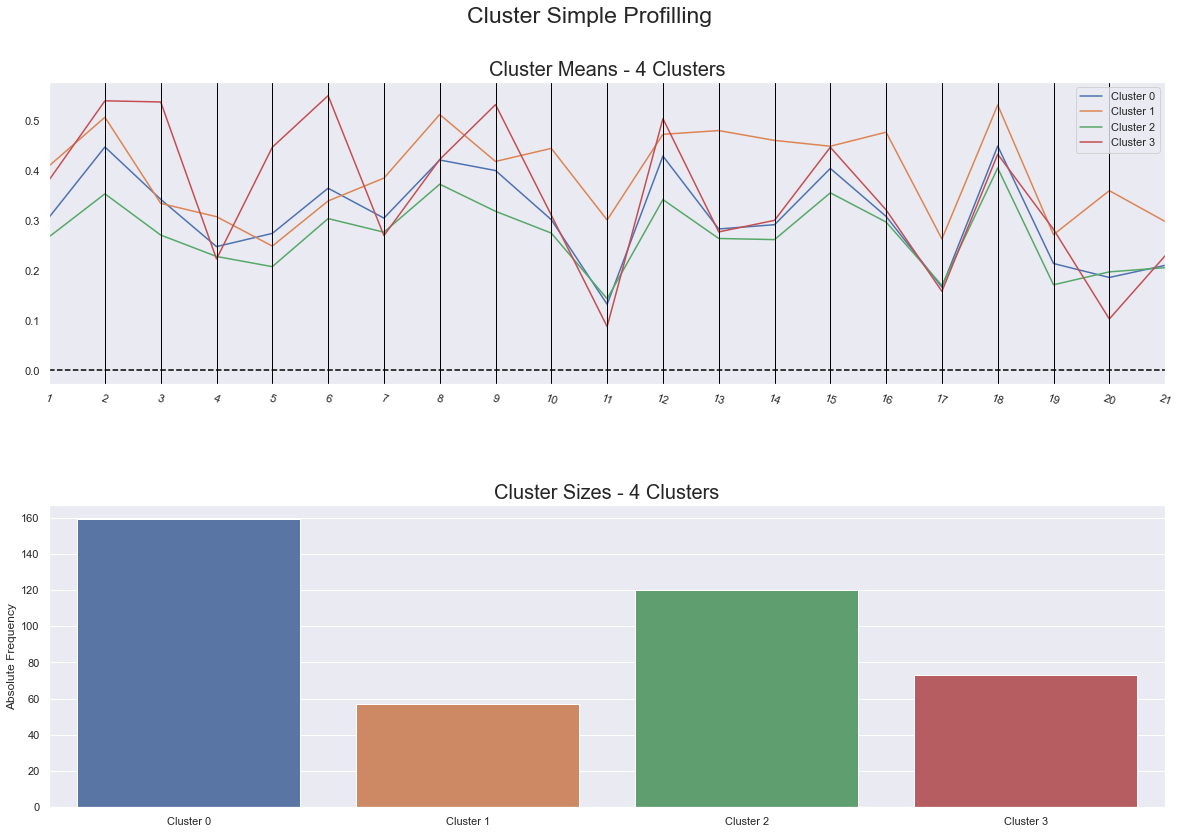

In [100]:
cluster_profiles(
    df = df_concat, 
    label_columns = ['kmeans labels'], 
    figsize = (20, 13), 
)

In [101]:
r2(df_final, kmeans_labels)

0.4819074555557039

In [102]:
#using davies bouldin index
davies_bouldin_score(df_final, kmeans_labels)

1.686687930404631

In [103]:
#using calinski_harabasz
metrics.calinski_harabasz_score(df_final, kmeans_labels)

125.88126005266356

In [104]:
## for dashboard
# Characterizing the final clusters
df_concat = pd.concat((df_final_not_norm.reset_index(), pd.Series(kmeans_labels.astype(int), name='kmeans labels')), axis=1)
df_concat
#df_centroids = df_concat.groupby('kmeans labels').mean()
#df_centroids

,Point-of-Sale_ID,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,kmeans labels
0,1,94398.0,28944.0,12091.0,436.0,2842.0,6138.0,1865.0,9316.0,105672.0,...,1235.0,21110.0,19742.0,4665.0,378.0,23065.0,466.0,316.0,34716.0,0
1,2,77916.0,32978.0,8814.0,212.0,2256.0,4652.0,2741.0,8900.0,92484.0,...,1101.0,22136.0,19383.0,4647.0,59.0,18588.0,251.0,250.0,20687.0,2
2,3,110754.0,48688.0,14323.0,536.0,3393.0,10249.0,3182.0,11153.0,152604.0,...,1228.0,25660.0,26229.0,6729.0,187.0,27282.0,456.0,329.0,41373.0,3
3,4,115017.0,38398.0,11761.0,617.0,3646.0,7058.0,2014.0,10517.0,171198.0,...,1933.0,26054.0,33588.0,5840.0,563.0,29617.0,883.0,1898.0,83589.0,3
4,5,66385.0,33506.0,8505.0,705.0,3136.0,4552.0,1853.0,8703.0,125447.0,...,1225.0,33983.0,25513.0,7014.0,303.0,20211.0,531.0,632.0,39029.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,406,99340.0,41714.0,7892.0,272.0,4352.0,5697.0,2373.0,12587.0,83951.0,...,2898.0,35053.0,23473.0,6882.0,176.0,19695.0,543.0,690.0,41443.0,0
406,407,134946.0,46477.0,8017.0,609.0,3564.0,4886.0,3637.0,11314.0,120628.0,...,2809.0,29716.0,31296.0,10913.0,236.0,26788.0,619.0,1206.0,59642.0,1
407,408,86044.0,35552.0,6742.0,669.0,3107.0,3252.0,2152.0,8872.0,66279.0,...,2694.0,27543.0,22081.0,8981.0,45.0,23481.0,498.0,270.0,33224.0,0
408,409,79174.0,53816.0,7669.0,496.0,2828.0,2444.0,1943.0,11766.0,90151.0,...,2415.0,23617.0,14656.0,5231.0,168.0,22294.0,1156.0,631.0,33716.0,0


In [105]:
#df_concat.to_csv('Clusters_PreferencesPerspective_KMeans.csv',index=False)

In [106]:
## add column with cluster labels to the original dataset
df_concat1=df_concat[['Point-of-Sale_ID','kmeans labels']]
#df_concat11
df_with_clusters=df
df_with_clusters2=df_with_clusters.merge(df_concat1, left_on='Point-of-Sale_ID', right_on='Point-of-Sale_ID') #.rename(columns={"kmeans labels": "labels"})
df_with_clusters2

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,kmeans labels
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,0
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,0
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,0
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,0
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,0
...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,2
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,2
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,2
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,2


In [107]:
df_with_clusters_pref=df_with_clusters2

In [ ]:
#df_with_clusters2.to_csv('Big_Dataset_With_Clusters_Preferences_KMeans.csv',index=False)

In [26]:
#### TRYING WITH KMEANS + HC
### KMEANS + HIERARCHICAL
kmeans = KMeans(n_clusters=60, init='random', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
#kmeans_labels

In [27]:
df_concat1 = pd.concat((df_final, pd.Series(kmeans_labels.astype(int), name='kmeans + hierarquical')), axis=1)
df_concat1
df_centroids1 = df_concat1.groupby('kmeans + hierarquical').mean()

In [28]:
df_concat1=df_concat1.iloc[1:]
df_concat1

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,kmeans + hierarquical
1,0.407454,0.369579,0.746692,0.208157,0.125609,0.312366,0.151181,0.302431,0.389453,0.316171,...,0.125037,0.157418,0.240926,0.267494,0.129947,0.411779,0.103687,0.032050,0.185947,28.0
2,0.317126,0.441690,0.518457,0.089513,0.088016,0.223766,0.251663,0.279338,0.320910,0.175093,...,0.105091,0.175957,0.230949,0.266157,0.018214,0.305117,0.044081,0.023345,0.100875,58.0
3,0.497093,0.722516,0.902145,0.261123,0.160957,0.557477,0.302248,0.404408,0.633374,0.181227,...,0.123995,0.239633,0.421211,0.420814,0.063047,0.512246,0.100915,0.033764,0.226315,30.0
4,0.520456,0.538576,0.723708,0.304025,0.177188,0.367219,0.168273,0.369102,0.730014,0.292844,...,0.228937,0.246752,0.625730,0.354776,0.194746,0.567875,0.219296,0.240702,0.482314,39.0
5,0.253931,0.451128,0.496936,0.350636,0.144470,0.217803,0.149805,0.268402,0.492230,0.189405,...,0.123549,0.390022,0.401312,0.441985,0.103678,0.343784,0.121708,0.073727,0.212101,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.434539,0.597851,0.454242,0.121292,0.222479,0.286072,0.209452,0.484012,0.276561,0.266914,...,0.372581,0.409356,0.344617,0.432179,0.059194,0.331491,0.125035,0.081377,0.226740,26.0
407,0.629676,0.682993,0.462947,0.299788,0.171927,0.237718,0.354439,0.413345,0.467184,0.360688,...,0.359333,0.312921,0.562031,0.731615,0.080210,0.500476,0.146105,0.149433,0.337099,3.0
408,0.361671,0.487702,0.374147,0.331568,0.142610,0.140293,0.184102,0.277784,0.184714,0.214498,...,0.342215,0.273657,0.305931,0.588100,0.013310,0.421690,0.112559,0.025983,0.176900,11.0
409,0.324020,0.814183,0.438710,0.239936,0.124711,0.092118,0.160128,0.438437,0.308785,0.197119,...,0.300685,0.202718,0.099578,0.309538,0.056392,0.393410,0.294982,0.073595,0.179883,32.0


In [29]:
# Setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc.fit_predict(df_centroids1[metric])

array([45, 49, 55, 31, 36, 34, 33, 41, 43, 42, 56, 35, 50, 20, 59, 29, 27,
       44, 54, 57, 53, 40, 58, 39, 46, 30, 47, 48, 51, 32, 17, 24, 15, 23,
       16, 22, 21, 26, 28, 14, 37, 13, 52, 10,  7, 38, 18, 25,  6, 11, 12,
        8,  5,  2,  3, 19,  9,  4,  1,  0], dtype=int64)

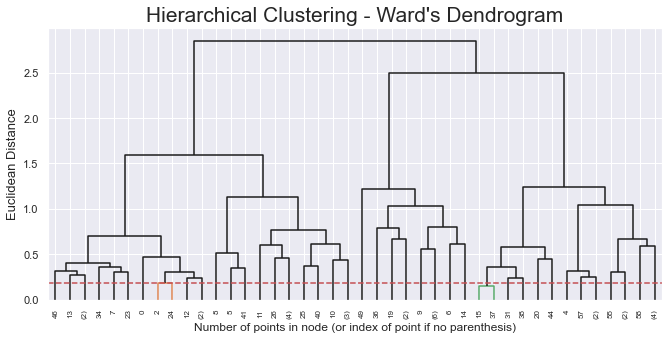

In [30]:
# Dendrogram

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hc.children_, hc.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.1825
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [31]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df_centroids1[metric])
hc4_labels

array([3, 0, 3, 2, 0, 1, 2, 3, 1, 2, 1, 1, 3, 3, 2, 0, 1, 0, 0, 2, 0, 0,
       2, 3, 3, 1, 1, 0, 3, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 0, 1, 1, 2, 1,
       0, 2, 3, 2, 1, 2, 3, 1, 1, 1, 1, 0, 3, 0, 0, 3], dtype=int64)

In [32]:
df_concat1['kmeans + hierarquical'] = df_concat1['kmeans + hierarquical'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  49, 50,  51,
        52, 53,  54, 55,  56,  57,  58,  59]
                                                                  ,hc4_labels.astype(int))

In [33]:
df_concat1

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,kmeans + hierarquical
1,0.407454,0.369579,0.746692,0.208157,0.125609,0.312366,0.151181,0.302431,0.389453,0.316171,...,0.125037,0.157418,0.240926,0.267494,0.129947,0.411779,0.103687,0.032050,0.185947,3.0
2,0.317126,0.441690,0.518457,0.089513,0.088016,0.223766,0.251663,0.279338,0.320910,0.175093,...,0.105091,0.175957,0.230949,0.266157,0.018214,0.305117,0.044081,0.023345,0.100875,0.0
3,0.497093,0.722516,0.902145,0.261123,0.160957,0.557477,0.302248,0.404408,0.633374,0.181227,...,0.123995,0.239633,0.421211,0.420814,0.063047,0.512246,0.100915,0.033764,0.226315,0.0
4,0.520456,0.538576,0.723708,0.304025,0.177188,0.367219,0.168273,0.369102,0.730014,0.292844,...,0.228937,0.246752,0.625730,0.354776,0.194746,0.567875,0.219296,0.240702,0.482314,0.0
5,0.253931,0.451128,0.496936,0.350636,0.144470,0.217803,0.149805,0.268402,0.492230,0.189405,...,0.123549,0.390022,0.401312,0.441985,0.103678,0.343784,0.121708,0.073727,0.212101,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.434539,0.597851,0.454242,0.121292,0.222479,0.286072,0.209452,0.484012,0.276561,0.266914,...,0.372581,0.409356,0.344617,0.432179,0.059194,0.331491,0.125035,0.081377,0.226740,1.0
407,0.629676,0.682993,0.462947,0.299788,0.171927,0.237718,0.354439,0.413345,0.467184,0.360688,...,0.359333,0.312921,0.562031,0.731615,0.080210,0.500476,0.146105,0.149433,0.337099,2.0
408,0.361671,0.487702,0.374147,0.331568,0.142610,0.140293,0.184102,0.277784,0.184714,0.214498,...,0.342215,0.273657,0.305931,0.588100,0.013310,0.421690,0.112559,0.025983,0.176900,1.0
409,0.324020,0.814183,0.438710,0.239936,0.124711,0.092118,0.160128,0.438437,0.308785,0.197119,...,0.300685,0.202718,0.099578,0.309538,0.056392,0.393410,0.294982,0.073595,0.179883,2.0


In [34]:
kmeans_hc=df_concat1.groupby('kmeans + hierarquical').mean()
kmeans_hc

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
kmeans + hierarquical,,,,,,,,,,,,,,,,,,,,,
0.0,0.381820,0.525910,0.516123,0.239706,0.433035,0.533501,0.265272,0.371064,0.528867,0.321214,...,0.530491,0.291967,0.292314,0.464611,0.334316,0.170898,0.442287,0.317351,0.111462,0.248887
1.0,0.269038,0.314893,0.231605,0.240221,0.173429,0.251284,0.230751,0.309752,0.269972,0.297847,...,0.312502,0.281888,0.275832,0.330592,0.345857,0.194885,0.387874,0.171581,0.257415,0.222871
2.0,0.392121,0.525718,0.334698,0.314862,0.252435,0.329748,0.408507,0.534221,0.414228,0.462699,...,0.467725,0.484452,0.495909,0.411371,0.460302,0.215705,0.510506,0.234987,0.312052,0.280632
3.0,0.252866,0.405543,0.306383,0.204449,0.238166,0.353509,0.315945,0.474709,0.371687,0.210148,...,0.368762,0.195470,0.206020,0.396154,0.214844,0.148808,0.444740,0.153957,0.153698,0.157674


In [35]:
df_concat1['kmeans + hierarquical'].value_counts().sort_values(ascending=False)

0.0    117
3.0    112
1.0     93
2.0     87
Name: kmeans + hierarquical, dtype: int64

In [36]:
#### EVALUATION

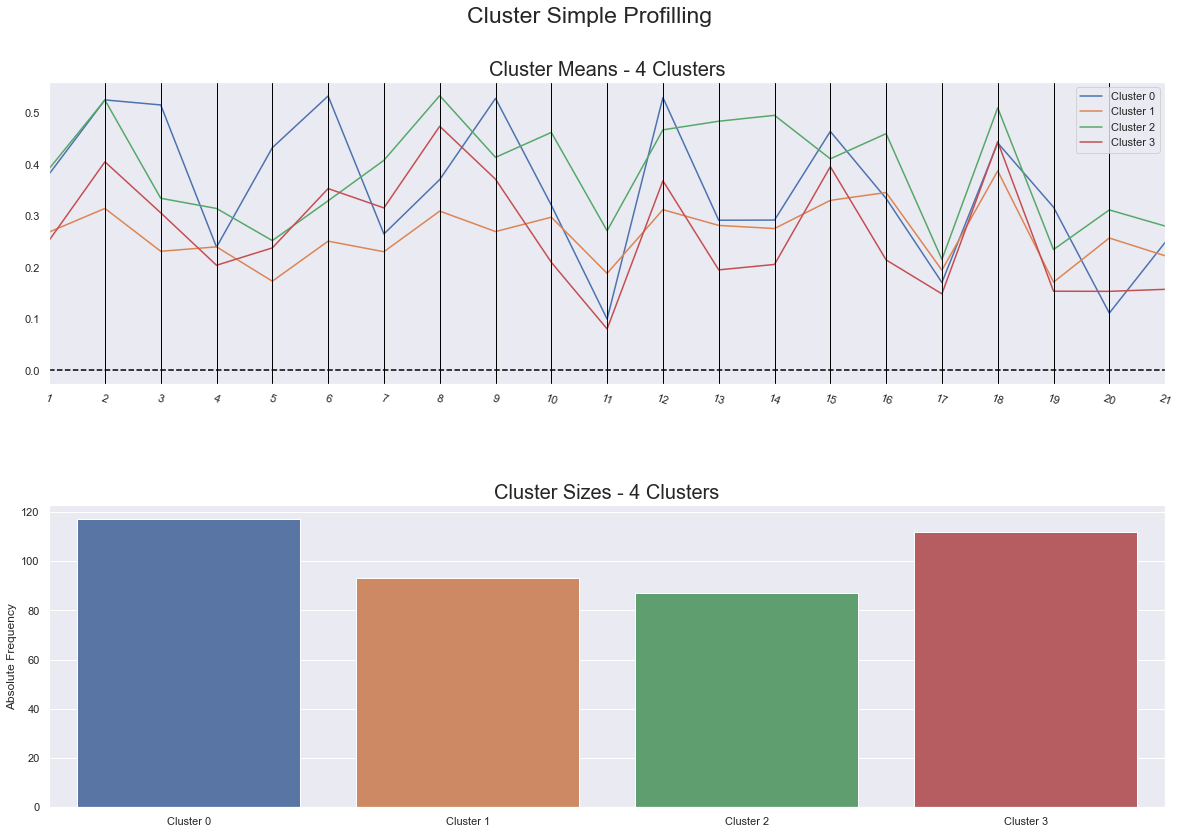

In [37]:
cluster_profiles(
    df = df_concat1, 
    label_columns = ['kmeans + hierarquical'], 
    figsize = (20, 13), 
)

In [38]:
# there is only 1 nan
df_concat1['kmeans + hierarquical']=df_concat1['kmeans + hierarquical'].fillna(0).astype('int64')

In [41]:
r2(df_final,df_concat1['kmeans + hierarquical'])

0.21076230573456567

In [42]:
#using davies bouldin index
davies_bouldin_score(df_final, df_concat1['kmeans + hierarquical'])

2.7422468462614926

In [43]:
#using calinski_harabasz
metrics.calinski_harabasz_score(df_final, df_concat1['kmeans + hierarquical'])

36.140145843674084

In [44]:
## for dashboard
### KMEANS + HIERARCHICAL
kmeans = KMeans(n_clusters=60, init='random', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
#kmeans_labels

In [45]:
df_concat1 = pd.concat((df_final_not_norm.reset_index(), pd.Series(kmeans_labels.astype(int), name='kmeans + hierarquical')), axis=1)
df_concat1
df_centroids1 = df_concat1.groupby('kmeans + hierarquical').mean()

In [46]:
df_concat1

,Point-of-Sale_ID,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,kmeans + hierarquical
0,1,94398.0,28944.0,12091.0,436.0,2842.0,6138.0,1865.0,9316.0,105672.0,...,1235.0,21110.0,19742.0,4665.0,378.0,23065.0,466.0,316.0,34716.0,20
1,2,77916.0,32978.0,8814.0,212.0,2256.0,4652.0,2741.0,8900.0,92484.0,...,1101.0,22136.0,19383.0,4647.0,59.0,18588.0,251.0,250.0,20687.0,28
2,3,110754.0,48688.0,14323.0,536.0,3393.0,10249.0,3182.0,11153.0,152604.0,...,1228.0,25660.0,26229.0,6729.0,187.0,27282.0,456.0,329.0,41373.0,58
3,4,115017.0,38398.0,11761.0,617.0,3646.0,7058.0,2014.0,10517.0,171198.0,...,1933.0,26054.0,33588.0,5840.0,563.0,29617.0,883.0,1898.0,83589.0,30
4,5,66385.0,33506.0,8505.0,705.0,3136.0,4552.0,1853.0,8703.0,125447.0,...,1225.0,33983.0,25513.0,7014.0,303.0,20211.0,531.0,632.0,39029.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,406,99340.0,41714.0,7892.0,272.0,4352.0,5697.0,2373.0,12587.0,83951.0,...,2898.0,35053.0,23473.0,6882.0,176.0,19695.0,543.0,690.0,41443.0,3
406,407,134946.0,46477.0,8017.0,609.0,3564.0,4886.0,3637.0,11314.0,120628.0,...,2809.0,29716.0,31296.0,10913.0,236.0,26788.0,619.0,1206.0,59642.0,26
407,408,86044.0,35552.0,6742.0,669.0,3107.0,3252.0,2152.0,8872.0,66279.0,...,2694.0,27543.0,22081.0,8981.0,45.0,23481.0,498.0,270.0,33224.0,3
408,409,79174.0,53816.0,7669.0,496.0,2828.0,2444.0,1943.0,11766.0,90151.0,...,2415.0,23617.0,14656.0,5231.0,168.0,22294.0,1156.0,631.0,33716.0,11


In [47]:
# Setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc.fit_predict(df_centroids1[metric])

array([52, 59, 55, 40, 57, 56, 33, 47, 27, 34, 49, 41, 32, 51, 36, 48, 45,
       50, 58, 30, 29, 37, 46, 39, 44, 28, 43, 22, 13, 14, 53, 31, 15, 19,
       42, 24, 35, 16, 54, 26, 20, 25,  7, 21, 38, 12, 23, 18, 10, 17, 11,
        9,  8,  3,  4,  6,  1,  5,  2,  0], dtype=int64)

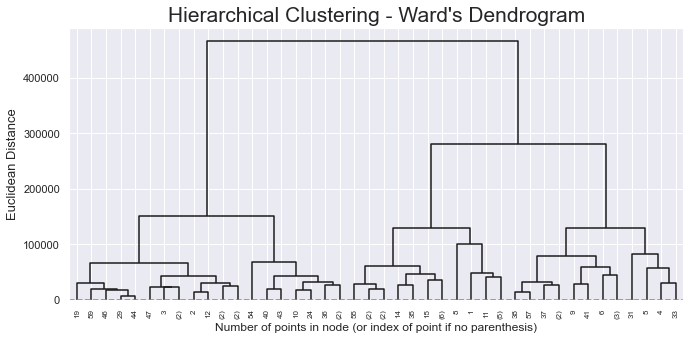

In [48]:
# Dendrogram

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hc.children_, hc.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.1825
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [49]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df_centroids1[metric])
hc4_labels

array([3, 2, 3, 3, 0, 0, 0, 2, 2, 0, 1, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 1, 3, 2, 0, 3, 3, 0, 0, 0, 0, 3, 2, 1, 0, 0, 2, 1, 0, 0, 1,
       3, 2, 3, 3, 3, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 3], dtype=int64)

In [50]:
df_concat1['kmeans + hierarquical'] = df_concat1['kmeans + hierarquical'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  49, 50,  51,
        52, 53,  54, 55,  56,  57,  58,  59]
                                                                  ,hc4_labels.astype(int))

In [51]:
df_concat1
#df_concat1.groupby('kmeans + hierarquical').mean()

,Point-of-Sale_ID,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,kmeans + hierarquical
0,1,94398.0,28944.0,12091.0,436.0,2842.0,6138.0,1865.0,9316.0,105672.0,...,1235.0,21110.0,19742.0,4665.0,378.0,23065.0,466.0,316.0,34716.0,2
1,2,77916.0,32978.0,8814.0,212.0,2256.0,4652.0,2741.0,8900.0,92484.0,...,1101.0,22136.0,19383.0,4647.0,59.0,18588.0,251.0,250.0,20687.0,3
2,3,110754.0,48688.0,14323.0,536.0,3393.0,10249.0,3182.0,11153.0,152604.0,...,1228.0,25660.0,26229.0,6729.0,187.0,27282.0,456.0,329.0,41373.0,2
3,4,115017.0,38398.0,11761.0,617.0,3646.0,7058.0,2014.0,10517.0,171198.0,...,1933.0,26054.0,33588.0,5840.0,563.0,29617.0,883.0,1898.0,83589.0,0
4,5,66385.0,33506.0,8505.0,705.0,3136.0,4552.0,1853.0,8703.0,125447.0,...,1225.0,33983.0,25513.0,7014.0,303.0,20211.0,531.0,632.0,39029.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,406,99340.0,41714.0,7892.0,272.0,4352.0,5697.0,2373.0,12587.0,83951.0,...,2898.0,35053.0,23473.0,6882.0,176.0,19695.0,543.0,690.0,41443.0,3
406,407,134946.0,46477.0,8017.0,609.0,3564.0,4886.0,3637.0,11314.0,120628.0,...,2809.0,29716.0,31296.0,10913.0,236.0,26788.0,619.0,1206.0,59642.0,2
407,408,86044.0,35552.0,6742.0,669.0,3107.0,3252.0,2152.0,8872.0,66279.0,...,2694.0,27543.0,22081.0,8981.0,45.0,23481.0,498.0,270.0,33224.0,3
408,409,79174.0,53816.0,7669.0,496.0,2828.0,2444.0,1943.0,11766.0,90151.0,...,2415.0,23617.0,14656.0,5231.0,168.0,22294.0,1156.0,631.0,33716.0,2


In [105]:
#df_concat1.to_csv('Clusters_PreferencesPerspective_KMeansHC.csv',index=False)

In [52]:
## add column with cluster labels to the original dataset
df_concat11=df_concat1[['Point-of-Sale_ID','kmeans + hierarquical']]
#df_concat11
df_with_clusters=df
df_with_clusters2=df_with_clusters.merge(df_concat11, left_on='Point-of-Sale_ID', right_on='Point-of-Sale_ID').rename(columns={"kmeans labels": "labels"})
df_with_clusters2

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,kmeans + hierarquical
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,3
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,3
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,3
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,3
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,3
...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,1
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,1
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,1
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,1


In [108]:
#df_with_clusters2.to_csv('Big_Dataset_With_Clusters_Preferences_KMeansHC.csv',index=False)

In [54]:
#### TRYING WITH KPROTOTYPES
df_preferences2= pd.DataFrame(df.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['ProductFamily_ID'].count().reset_index(drop=True))
df_preferences2=df_preferences2.rename(columns={'ProductFamily_ID':'total_prod_fam'})
df_preferences2

,total_prod_fam
0,27717
1,8661
2,2487
3,237
4,1505
...,...
8605,141
8606,9452
8607,332
8608,564


In [55]:
df_preferences= df.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Unit'].sum().reset_index()
df_preferences=df_preferences.rename(columns={'Unit':'total_units'})#.set_index('Point-of-Sale_ID')
df_preferences=pd.merge(df_preferences, df_preferences2, left_index=True, right_index=True)
df_preferences

,Point-of-Sale_ID,ProductFamily_ID,total_units,total_prod_fam
0,1,1,94398.0,27717
1,1,2,28944.0,8661
2,1,3,12091.0,2487
3,1,4,436.0,237
4,1,5,2842.0,1505
...,...,...,...,...
8605,410,17,229.0,141
8606,410,18,26131.0,9452
8607,410,19,722.0,332
8608,410,20,2267.0,564


In [56]:
df_preferences['total_prod_fam'].describe()

count      8610.000000
mean       8824.630314
std       13822.422992
min           4.000000
25%         811.000000
50%        2146.000000
75%        9785.000000
max      116184.000000
Name: total_prod_fam, dtype: float64

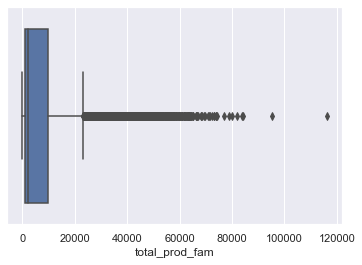

In [57]:
sns.boxplot(x=df_preferences['total_prod_fam'])

In [58]:
df_preferences['total_units'].describe()

count      8610.000000
mean      22816.917422
std       33823.885833
min           7.000000
25%        2019.500000
50%        6698.500000
75%       29485.250000
max      223145.000000
Name: total_units, dtype: float64

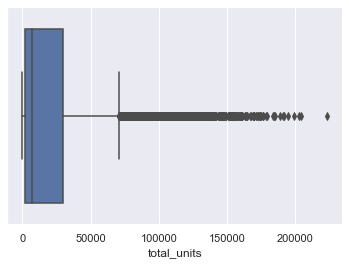

In [59]:
sns.boxplot(x=df_preferences['total_units'])

In [60]:
# outliers
filters = ((df_preferences['total_units']>75000) | (df_preferences['total_prod_fam']>20000))
df_preferences_out = df_preferences[filters]
df_preferences_in = df_preferences[~filters]
df_preferences_final=df_preferences_in
df_preferences_final

,Point-of-Sale_ID,ProductFamily_ID,total_units,total_prod_fam
1,1,2,28944.0,8661
2,1,3,12091.0,2487
3,1,4,436.0,237
4,1,5,2842.0,1505
5,1,6,6138.0,1628
...,...,...,...,...
8604,410,16,10691.0,5498
8605,410,17,229.0,141
8606,410,18,26131.0,9452
8607,410,19,722.0,332


In [61]:
df_preferences_final['total_units'].describe()

count     7250.000000
mean     10406.268828
std      12475.421687
min          7.000000
25%       1516.750000
50%       4662.000000
75%      15614.750000
max      71911.000000
Name: total_units, dtype: float64

In [62]:
df_preferences_final['total_prod_fam'].describe()

count     7250.000000
mean      3452.528966
std       4259.483233
min          4.000000
25%        628.000000
50%       1577.000000
75%       4907.750000
max      19953.000000
Name: total_prod_fam, dtype: float64

In [63]:
# create binary variables which from a certain threshold the pos is considered a preference (and assumes value 1)
def to_bin(x):
    if (x >= 60000) | (x >= 10000):
        return 1
    else: 
        return 0

    
df_preferences_final['total_units_bin'] = df_preferences_final['total_units'].apply(to_bin)
df_preferences_final['total_prod_fam_bin'] = df_preferences_final['total_prod_fam'].apply(to_bin)

<ipython-input-63-555c4ceced0b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preferences_final['total_units_bin'] = df_preferences_final['total_units'].apply(to_bin)
<ipython-input-63-555c4ceced0b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preferences_final['total_prod_fam_bin'] = df_preferences_final['total_prod_fam'].apply(to_bin)


In [64]:
df_preferences_final

,Point-of-Sale_ID,ProductFamily_ID,total_units,total_prod_fam,total_units_bin,total_prod_fam_bin
1,1,2,28944.0,8661,1,0
2,1,3,12091.0,2487,1,0
3,1,4,436.0,237,0,0
4,1,5,2842.0,1505,0,0
5,1,6,6138.0,1628,0,0
...,...,...,...,...,...,...
8604,410,16,10691.0,5498,1,0
8605,410,17,229.0,141,0,0
8606,410,18,26131.0,9452,1,0
8607,410,19,722.0,332,0,0


In [65]:
df_preferences_final['total_units']=df_preferences_final['total_units'].astype(int)

<ipython-input-65-6001b9d1a0e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preferences_final['total_units']=df_preferences_final['total_units'].astype(int)


In [66]:
metric=['total_units','total_prod_fam']
cat=['total_units_bin','total_prod_fam_bin']
features=['total_units','total_prod_fam','total_units_bin','total_prod_fam_bin']

In [67]:
#K-prototypes clustering 
kproto = KPrototypes(n_clusters= 4 , init='Cao', n_jobs = -1)
profile_cat_nmr = [2,3]
kpro_prof = kproto.fit_predict(df_preferences_final[features], categorical=profile_cat_nmr)

#number of donors per cluster
pd.Series(kpro_prof).value_counts()

2    4377
3    1267
1    1134
0     472
dtype: int64

In [68]:
## for dashboard
# Characterizing the final clusters
df_concat = pd.concat((df_preferences_final.reset_index(), pd.Series(kpro_prof.astype(int), name='kprototypes labels')), axis=1)
df_concat

,index,Point-of-Sale_ID,ProductFamily_ID,total_units,total_prod_fam,total_units_bin,total_prod_fam_bin,kprototypes labels
0,1,1,2,28944,8661,1,0,1
1,2,1,3,12091,2487,1,0,3
2,3,1,4,436,237,0,0,2
3,4,1,5,2842,1505,0,0,2
4,5,1,6,6138,1628,0,0,2
...,...,...,...,...,...,...,...,...
7245,8604,410,16,10691,5498,1,0,3
7246,8605,410,17,229,141,0,0,2
7247,8606,410,18,26131,9452,1,0,1
7248,8607,410,19,722,332,0,0,2


In [69]:
#### EVALUATION

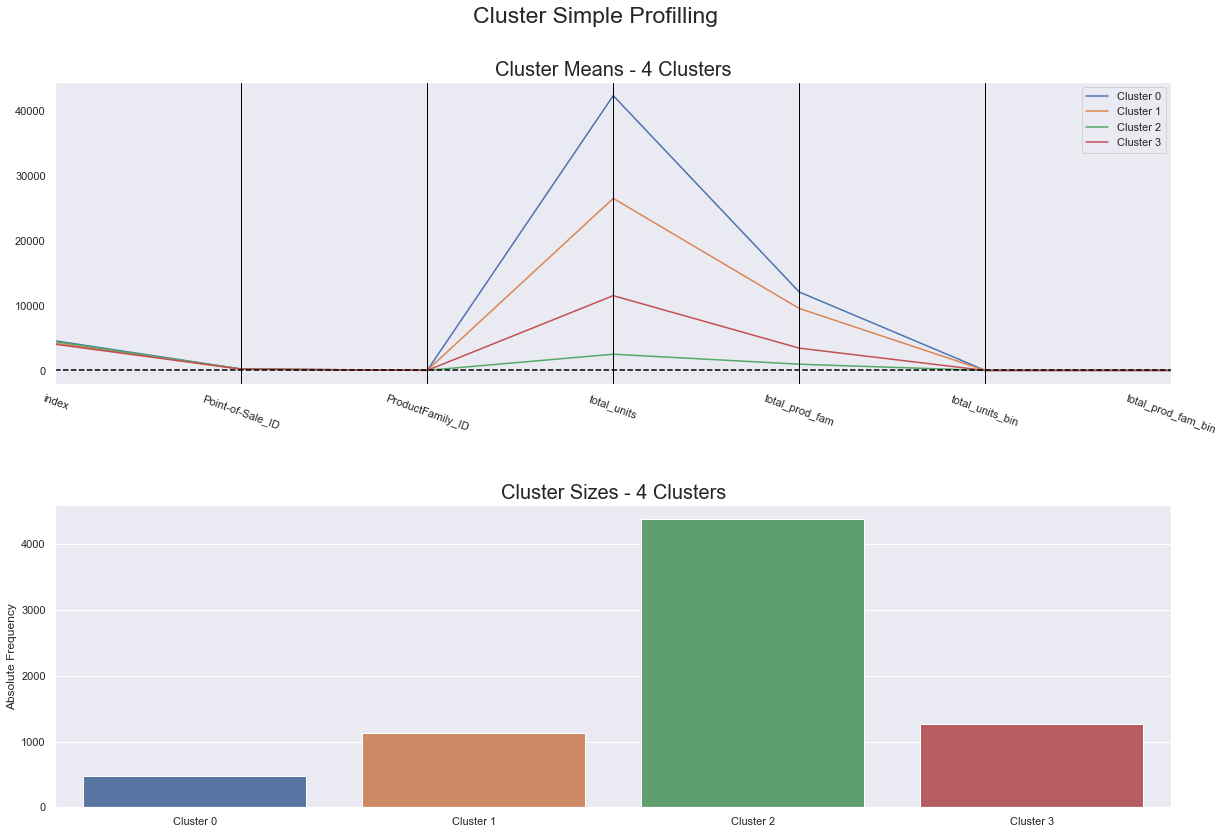

In [70]:
cluster_profiles(
    df = df_concat, 
    label_columns = ['kprototypes labels'], 
    figsize = (20, 13), 
)

In [71]:
# create another cluster with the outliers
df_concat2=pd.concat((df_concat.reset_index(), df_preferences_out))
df_concat2['kprototypes labels'] = df_concat2['kprototypes labels'].replace(np.nan, 5)
df_concat2

,level_0,index,Point-of-Sale_ID,ProductFamily_ID,total_units,total_prod_fam,total_units_bin,total_prod_fam_bin,kprototypes labels
0,0.0,1.0,1,2,28944.0,8661,1.0,0.0,1.0
1,1.0,2.0,1,3,12091.0,2487,1.0,0.0,3.0
2,2.0,3.0,1,4,436.0,237,0.0,0.0,2.0
3,3.0,4.0,1,5,2842.0,1505,0.0,0.0,2.0
4,4.0,5.0,1,6,6138.0,1628,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
8588,NaN,NaN,409,21,33716.0,20946,NaN,NaN,5.0
8589,NaN,NaN,410,1,136087.0,35002,NaN,NaN,5.0
8597,NaN,NaN,410,9,159550.0,31177,NaN,NaN,5.0
8600,NaN,NaN,410,12,108149.0,47177,NaN,NaN,5.0


In [72]:
## add column with cluster labels to the original dataset
#df_concat22=df_concat2[['Point-of-Sale_ID','kprototypes labels']]
#df_concat22
#df_with_clusters_kprot=df
#df_with_clusters_kprot2=df_with_clusters_kprot.merge(df_concat22, left_on='Point-of-Sale_ID', right_on='Point-of-Sale_ID').rename(columns={"kprototypes labels": "kprot_labels"})
#df_with_clusters_kprot2

In [30]:
##### CLUSTERING - VALUE PERSPECTIVE
# create new data frames with new variables to merge in the next step
sum_= df.groupby('Point-of-Sale_ID')[['Unit','Price']].sum().rename(columns={"Unit": "total_units", "Price": "total_price"})
avg_=df.groupby('Point-of-Sale_ID')[['Unit','Price']].mean().rename(columns={"Unit": "avg_units", "Price": "avg_price"})
sdv_=df.groupby('Point-of-Sale_ID')[['Unit','Price']].std().rename(columns={"Unit": "std_units", "Price": "std_price"})
maxdate_=df.groupby('Point-of-Sale_ID')['Date'].max() 

df_ax_nrdays=df.groupby(['Point-of-Sale_ID','Date']).count().reset_index()
ac=df_ax_nrdays[['Point-of-Sale_ID','Date']].groupby('Point-of-Sale_ID')['Date'].count()

df_axx= df.groupby(['Point-of-Sale_ID','Date']).count().reset_index()
recent_date=df_axx[['Point-of-Sale_ID','Date']].groupby('Point-of-Sale_ID')['Date'].max()
old_date=df_axx[['Point-of-Sale_ID','Date']].groupby('Point-of-Sale_ID')['Date'].min()

In [31]:
# create a final data frame with all the variables 
df1=pd.merge(sum_, avg_, left_index=True, right_index=True)

df2=pd.merge(df1, sdv_, left_index=True, right_index=True)

df3=pd.merge(df2, maxdate_, left_index=True, right_index=True).rename(columns={"Date":"last_date"})

df4=pd.merge(df3, ac, left_index=True, right_index=True)
df4=df4.rename(columns={"Date":"nr_days"})

df5=pd.merge(df4, recent_date, left_index=True, right_index=True).rename(columns={"Date":"recent_date"})

df6=pd.merge(df5, old_date, left_index=True, right_index=True).rename(columns={"Date":"old_date"})
df6['difference'] = (df6['recent_date'] - df6['old_date']).dt.days
df6=df6.drop(['recent_date', 'old_date'], axis=1)
df_final_not_norm=df6
df_final_not_norm

,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference
Point-of-Sale_ID,,,,,,,,,
1,435140.0,7.184216e+08,2.638971,4356.975083,2.953560,9426.485047,2019-11-01,1401,1400
2,381211.0,6.137543e+08,2.429535,3911.579922,2.925116,8992.642910,2019-11-01,1401,1400
3,577380.0,9.737919e+08,2.519297,4248.970752,3.110368,10107.390354,2019-11-01,1401,1400
4,690137.0,1.070928e+09,2.250870,3492.811978,2.420901,7180.284422,2019-11-01,1401,1400
5,469668.0,7.288484e+08,2.385700,3702.218786,2.770878,7440.028139,2019-11-01,1401,1400
...,...,...,...,...,...,...,...,...,...
406,471721.0,7.977428e+08,2.979316,5038.417955,3.733143,10736.763299,2019-11-01,1401,1400
407,611666.0,9.738926e+08,2.789162,4440.894390,3.387809,8880.066653,2019-11-01,1401,1400
408,405802.0,6.593004e+08,2.647784,4301.814375,2.892608,8510.484147,2019-11-01,1401,1400


In [32]:
#df_value_all=df_final_not_norm

In [33]:
metric=['total_units', 'total_price', 'avg_units', 'avg_price', 'std_units','std_price', 'nr_days','difference']
non_metric=['ProductFamily_ID', 'ProductCategory_ID', 'ProductBrand_ID','ProductName_ID']

In [34]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=2, ncols=len(label_columns), figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=axes[0, 0])
        sns.barplot(x=label, y="counts", data=counts, ax=axes[1, 0])

        # Setting Layout
        handles, _ = axes[0, 0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        axes[0, 0].annotate(titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        axes[0, 0].legend(handles, cluster_labels) # Adaptable to number of clusters
        axes[0, 0].axhline(color="black", linestyle="--")
        axes[0, 0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=20)
        axes[0, 0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        axes[1, 0].set_xticklabels(cluster_labels)
        axes[1 ,0].set_xlabel("")
        axes[1, 0].set_ylabel("Absolute Frequency")
        axes[1, 0].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=20)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [35]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

In [36]:
#### scaling data with MinMax Scaler
df_final=df_final_not_norm.copy()
df_scaled = MinMaxScaler().fit_transform(df_final[metric])
df_final[metric]=df_scaled
df_final

,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference
Point-of-Sale_ID,,,,,,,,,
1,0.369805,0.359857,0.384771,0.334325,0.325256,0.397923,2019-11-01,1.00,1.000000
2,0.297294,0.279440,0.221180,0.205607,0.314167,0.358292,2019-11-01,1.00,1.000000
3,0.561055,0.556060,0.291293,0.303112,0.386390,0.460122,2019-11-01,1.00,1.000000
4,0.712664,0.630691,0.081626,0.084584,0.117594,0.192737,2019-11-01,1.00,1.000000
5,0.416230,0.367868,0.186941,0.145102,0.254036,0.216464,2019-11-01,1.00,1.000000
...,...,...,...,...,...,...,...,...,...
406,0.418990,0.420800,0.650613,0.531260,0.629184,0.517614,2019-11-01,1.00,1.000000
407,0.607155,0.556138,0.502084,0.358577,0.494552,0.348008,2019-11-01,1.00,1.000000
408,0.330358,0.314433,0.391654,0.318384,0.301494,0.314248,2019-11-01,1.00,1.000000


In [37]:
#df_final.to_csv('test.csv',index=False)

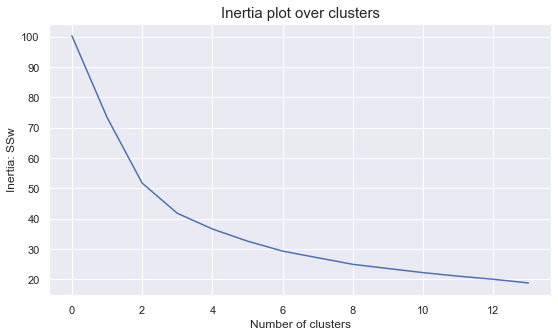

In [38]:
### KMEANS 
# To decide how many clusters to use in the clustering we will use the elbow method
range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_final[metric])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution


plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [39]:
# Final Kmeans clustering solution
number_clusters = 3
kmeans = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
kmeans_labels

# Characterizing the final clusters
df_concat = pd.concat((df_final, pd.Series(kmeans_labels.astype(int), name='kmeans labels')), axis=1)
df_centroids = df_concat.groupby('kmeans labels').mean()
df_centroids

,total_units,total_price,avg_units,avg_price,std_units,std_price,nr_days,difference
kmeans labels,,,,,,,,
0.0,0.484230,0.463171,0.454748,0.386907,0.407791,0.422263,0.914281,0.998687
1.0,0.362354,0.344126,0.337733,0.296041,0.251757,0.300231,0.707560,0.982924
2.0,0.417530,0.381354,0.304634,0.247513,0.219909,0.254828,0.900562,0.998572


In [40]:
df_concat['kmeans labels'].value_counts().sort_values(ascending=False)

2.0    215
0.0    125
1.0     70
Name: kmeans labels, dtype: int64

In [41]:
#### EVALUATION

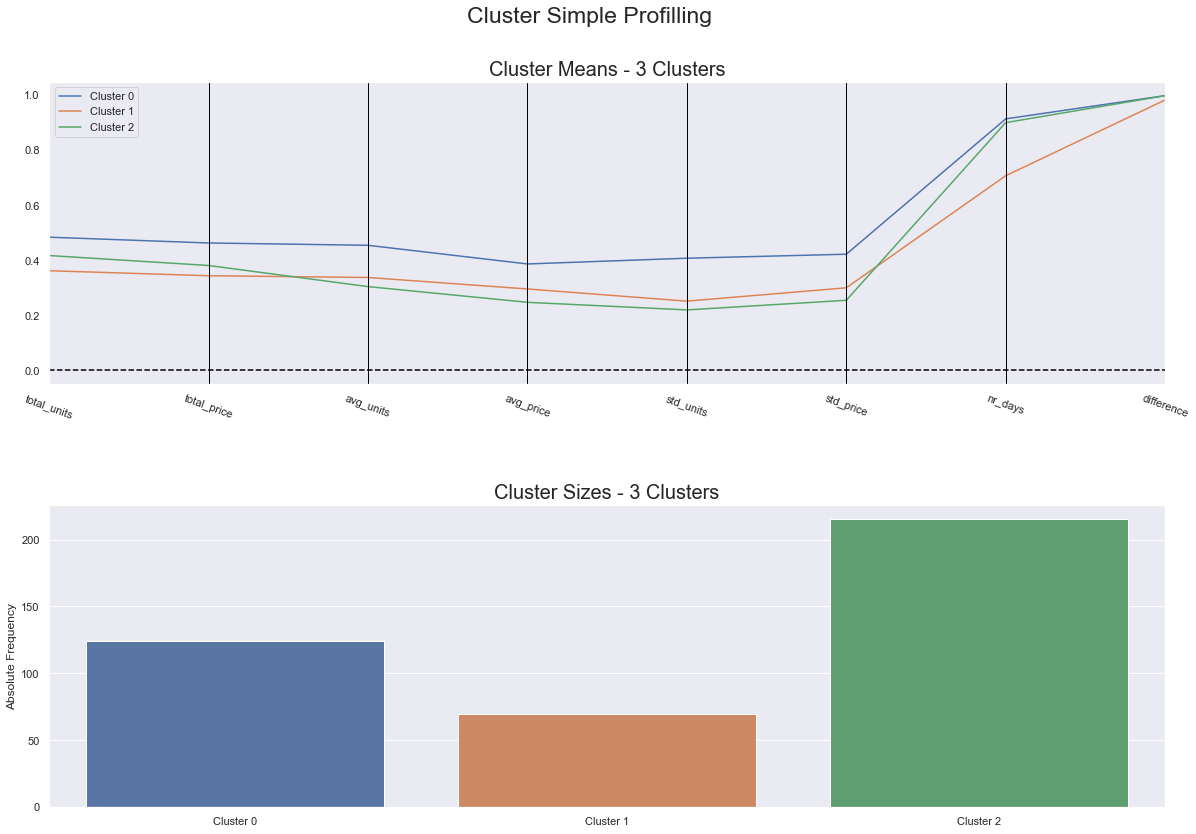

In [42]:
cluster_profiles(
    df = df_concat, 
    label_columns = ['kmeans labels'], 
    figsize = (20, 13), 
)

In [43]:
df_final_met=df_final.drop(['last_date'], axis=1)

In [44]:
r2(df_final_met, kmeans_labels)

0.4840746718128478

In [45]:
#using davies bouldin index
davies_bouldin_score(df_final_met, kmeans_labels)

1.110110655395414

In [46]:
#using calinski_harabasz
metrics.calinski_harabasz_score(df_final_met, kmeans_labels)

190.93692503923825

In [47]:
## for dashboard
# Characterizing the final clusters
df_concat = pd.concat((df_final_not_norm.reset_index(), pd.Series(kmeans_labels.astype(int), name='kmeans labels')), axis=1)
df_concat
#df_centroids = df_concat.groupby('kmeans labels').mean()
#df_centroids

,Point-of-Sale_ID,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference,kmeans labels
0,1,435140.0,7.184216e+08,2.638971,4356.975083,2.953560,9426.485047,2019-11-01,1401,1400,0
1,2,381211.0,6.137543e+08,2.429535,3911.579922,2.925116,8992.642910,2019-11-01,1401,1400,2
2,3,577380.0,9.737919e+08,2.519297,4248.970752,3.110368,10107.390354,2019-11-01,1401,1400,0
3,4,690137.0,1.070928e+09,2.250870,3492.811978,2.420901,7180.284422,2019-11-01,1401,1400,2
4,5,469668.0,7.288484e+08,2.385700,3702.218786,2.770878,7440.028139,2019-11-01,1401,1400,2
...,...,...,...,...,...,...,...,...,...,...,...
405,406,471721.0,7.977428e+08,2.979316,5038.417955,3.733143,10736.763299,2019-11-01,1401,1400,0
406,407,611666.0,9.738926e+08,2.789162,4440.894390,3.387809,8880.066653,2019-11-01,1401,1400,0
407,408,405802.0,6.593004e+08,2.647784,4301.814375,2.892608,8510.484147,2019-11-01,1401,1400,2
408,409,432553.0,7.879761e+08,2.907607,5296.748519,3.504420,12678.868224,2019-11-01,1389,1399,0


In [48]:
#df_concat.to_csv('Clusters_ValuePerspective_KMeans.csv',index=False)

In [49]:
## add column with cluster labels to the original dataset
df_concat1=df_concat[['Point-of-Sale_ID','kmeans labels']]
#df_concat11
df_with_clusters=df
df_with_clusters2=df_with_clusters.merge(df_concat1, left_on='Point-of-Sale_ID', right_on='Point-of-Sale_ID').rename(columns={"kmeans labels": "value_labels"})
df_with_clusters2

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,value_labels
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,2
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,2
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,2
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,2
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,2
...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,0
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,0
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,0
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,0


In [ ]:
# create a final dataframe with 2 columns with the clusters' labels for each perspective - preferences and value
df_with_clusters2['pref_labels']=df_with_clusters_pref['kmeans labels']
#df_with_clusters2=df_with_clusters2 #.rename(columns={'kmeans + hierarquical':'Value_Perspective_KM+HC', 'kmeans':'Preferences_Perspective_KM'})
df_with_clusters_finaaal=df_with_clusters2

In [130]:
df_with_clusters_finaaal

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,value_labels,pref_labels
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,2,0
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,2,0
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,2,0
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,2,0
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,2,0
...,...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,0,2
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,0,2
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,0,2
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,0,2


In [189]:
df_with_clusters_finaaal['value_labels'].unique()

array([2, 0, 1])

In [190]:
df_with_clusters_finaaal['pref_labels'].unique()

array([0, 2, 3, 1])

In [132]:
df_with_clusters_finaaal.to_csv('Big_Dataset_With_Clusters_FINALLL2.csv',index=False)

In [51]:
### KMEANS + HIERARCHICAL
kmeans = KMeans(n_clusters=60, init='random', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
#kmeans_labels

In [52]:
df_concat1 = pd.concat((df_final, pd.Series(kmeans_labels.astype(int), name='kmeans + hierarquical')), axis=1)
df_concat1
df_centroids1 = df_concat1.groupby('kmeans + hierarquical').mean()

In [53]:
df_concat1=df_concat1.iloc[1:]
df_concat1

,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference,kmeans + hierarquical
1,0.369805,0.359857,0.384771,0.334325,0.325256,0.397923,2019-11-01,1.00,1.000000,45.0
2,0.297294,0.279440,0.221180,0.205607,0.314167,0.358292,2019-11-01,1.00,1.000000,53.0
3,0.561055,0.556060,0.291293,0.303112,0.386390,0.460122,2019-11-01,1.00,1.000000,43.0
4,0.712664,0.630691,0.081626,0.084584,0.117594,0.192737,2019-11-01,1.00,1.000000,34.0
5,0.416230,0.367868,0.186941,0.145102,0.254036,0.216464,2019-11-01,1.00,1.000000,3.0
...,...,...,...,...,...,...,...,...,...,...
406,0.418990,0.420800,0.650613,0.531260,0.629184,0.517614,2019-11-01,1.00,1.000000,28.0
407,0.607155,0.556138,0.502084,0.358577,0.494552,0.348008,2019-11-01,1.00,1.000000,44.0
408,0.330358,0.314433,0.391654,0.318384,0.301494,0.314248,2019-11-01,1.00,1.000000,2.0
409,0.366327,0.413296,0.594601,0.605917,0.540014,0.695022,2019-11-01,0.95,0.995349,8.0


In [54]:
# Setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc.fit_predict(df_centroids1[metric])

array([52, 42, 51, 33, 45, 49, 37, 58, 47, 30, 43, 38, 46, 35, 40, 36, 59,
       18, 53, 54, 17, 26, 44, 50, 39, 25, 48, 29, 31, 24, 57, 34, 32, 56,
       23, 15, 41, 22, 19, 14, 55, 21, 28, 27, 11, 20, 16, 12,  9, 13,  7,
        6, 10,  4,  8,  5,  3,  2,  1,  0], dtype=int64)

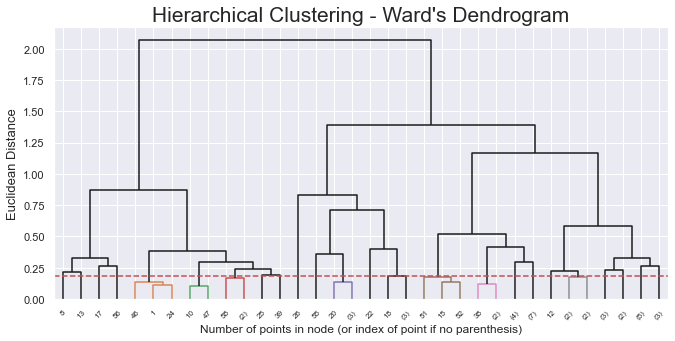

In [55]:
# Dendrogram

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hc.children_, hc.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.1825
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [56]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc4_labels = hc4lust.fit_predict(df_centroids1[metric])
hc4_labels

array([0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0,
       2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0], dtype=int64)

In [57]:
df_concat1['kmeans + hierarquical'] = df_concat1['kmeans + hierarquical'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  49, 50,  51,
        52, 53,  54, 55,  56,  57,  58,  59]
                                                                  ,hc4_labels.astype(int))

In [58]:
df_concat1

,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference,kmeans + hierarquical
1,0.369805,0.359857,0.384771,0.334325,0.325256,0.397923,2019-11-01,1.00,1.000000,0.0
2,0.297294,0.279440,0.221180,0.205607,0.314167,0.358292,2019-11-01,1.00,1.000000,0.0
3,0.561055,0.556060,0.291293,0.303112,0.386390,0.460122,2019-11-01,1.00,1.000000,0.0
4,0.712664,0.630691,0.081626,0.084584,0.117594,0.192737,2019-11-01,1.00,1.000000,0.0
5,0.416230,0.367868,0.186941,0.145102,0.254036,0.216464,2019-11-01,1.00,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
406,0.418990,0.420800,0.650613,0.531260,0.629184,0.517614,2019-11-01,1.00,1.000000,1.0
407,0.607155,0.556138,0.502084,0.358577,0.494552,0.348008,2019-11-01,1.00,1.000000,0.0
408,0.330358,0.314433,0.391654,0.318384,0.301494,0.314248,2019-11-01,1.00,1.000000,1.0
409,0.366327,0.413296,0.594601,0.605917,0.540014,0.695022,2019-11-01,0.95,0.995349,1.0


In [59]:
kmeans_hc=df_concat1.groupby('kmeans + hierarquical').mean()
kmeans_hc

,total_units,total_price,avg_units,avg_price,std_units,std_price,nr_days,difference
kmeans + hierarquical,,,,,,,,
0.0,0.416268,0.384821,0.311028,0.262077,0.233630,0.276724,0.915003,0.998656
1.0,0.522045,0.493806,0.518111,0.417719,0.464192,0.445553,0.895679,0.998622
2.0,0.360215,0.343184,0.334755,0.294665,0.252697,0.296870,0.666538,0.981538


In [60]:
df_concat1['kmeans + hierarquical'].value_counts().sort_values(ascending=False)

0.0    263
1.0     81
2.0     65
Name: kmeans + hierarquical, dtype: int64

In [61]:
#### EVALUATION

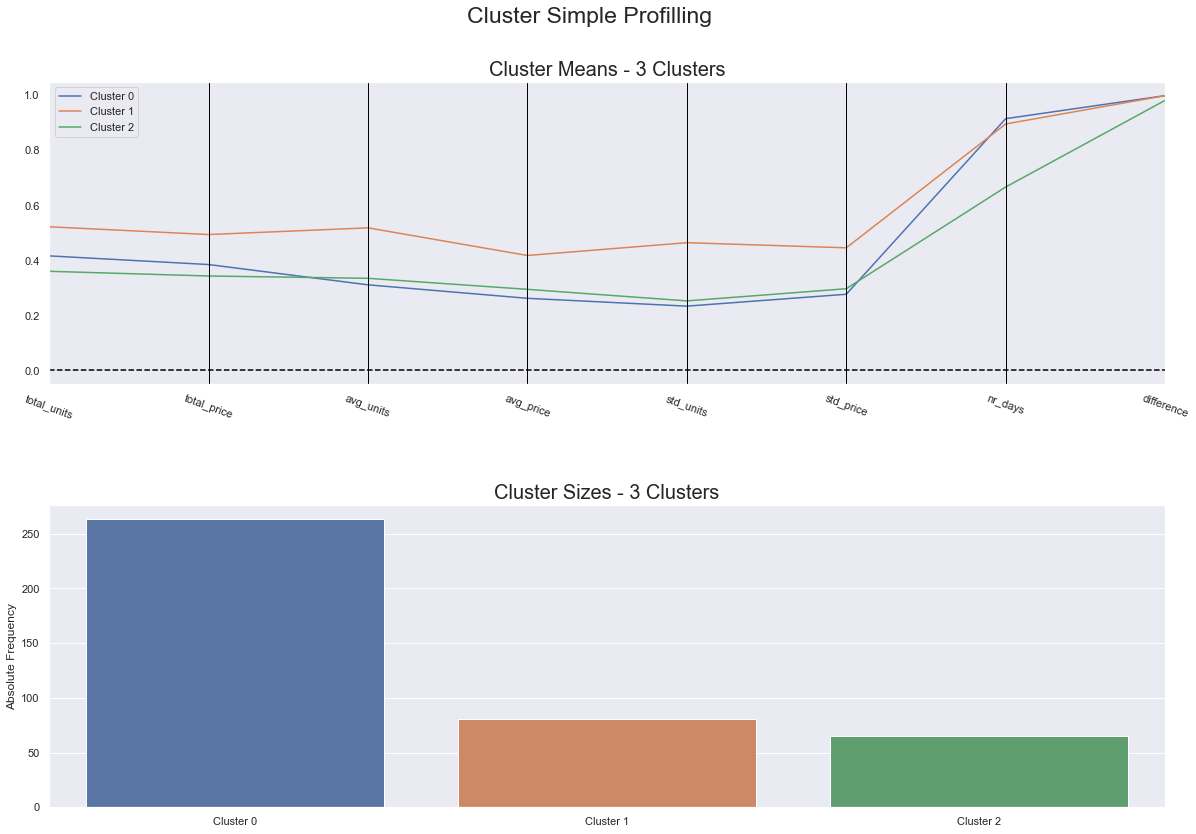

In [62]:
cluster_profiles(
    df = df_concat1, 
    label_columns = ['kmeans + hierarquical'], 
    figsize = (20, 13), 
)

In [65]:
# there is only 1 nan
df_concat1['kmeans + hierarquical']=df_concat1['kmeans + hierarquical'].fillna(0).astype('int64')

In [66]:
r2(df_final_met,df_concat1['kmeans + hierarquical'])

0.14464748396052185

In [67]:
#using davies bouldin index
davies_bouldin_score(df_final_met, df_concat1['kmeans + hierarquical'])

2.8974834410425

In [68]:
#using calinski_harabasz
metrics.calinski_harabasz_score(df_final_met, df_concat1['kmeans + hierarquical'])

34.41360425554371

In [69]:
## for dashboard
### KMEANS + HIERARCHICAL
kmeans = KMeans(n_clusters=60, init='random', n_init=15, random_state=1)
kmeans_labels = kmeans.fit_predict(df_final[metric])
#kmeans_labels

In [70]:
df_concat1 = pd.concat((df_final_not_norm.reset_index(), pd.Series(kmeans_labels.astype(int), name='kmeans + hierarquical')), axis=1)
df_concat1
df_centroids1 = df_concat1.groupby('kmeans + hierarquical').mean()

In [71]:
df_concat1

,Point-of-Sale_ID,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference,kmeans + hierarquical
0,1,435140.0,7.184216e+08,2.638971,4356.975083,2.953560,9426.485047,2019-11-01,1401,1400,49
1,2,381211.0,6.137543e+08,2.429535,3911.579922,2.925116,8992.642910,2019-11-01,1401,1400,45
2,3,577380.0,9.737919e+08,2.519297,4248.970752,3.110368,10107.390354,2019-11-01,1401,1400,53
3,4,690137.0,1.070928e+09,2.250870,3492.811978,2.420901,7180.284422,2019-11-01,1401,1400,43
4,5,469668.0,7.288484e+08,2.385700,3702.218786,2.770878,7440.028139,2019-11-01,1401,1400,34
...,...,...,...,...,...,...,...,...,...,...,...
405,406,471721.0,7.977428e+08,2.979316,5038.417955,3.733143,10736.763299,2019-11-01,1401,1400,39
406,407,611666.0,9.738926e+08,2.789162,4440.894390,3.387809,8880.066653,2019-11-01,1401,1400,28
407,408,405802.0,6.593004e+08,2.647784,4301.814375,2.892608,8510.484147,2019-11-01,1401,1400,44
408,409,432553.0,7.879761e+08,2.907607,5296.748519,3.504420,12678.868224,2019-11-01,1389,1399,2


In [72]:
# Setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc.fit_predict(df_centroids1[metric])

array([34, 32, 57, 52, 54, 42, 35, 53, 36, 51, 59, 55, 30, 25, 58, 33, 49,
       50, 48, 47, 39, 38, 16, 56, 26, 46, 45, 41, 43, 44, 20, 17, 37, 40,
       22, 31, 18, 29, 24, 28,  8, 19, 23, 12, 27, 21, 15, 14,  7, 13, 11,
        9,  5, 10,  3,  6,  4,  1,  2,  0], dtype=int64)

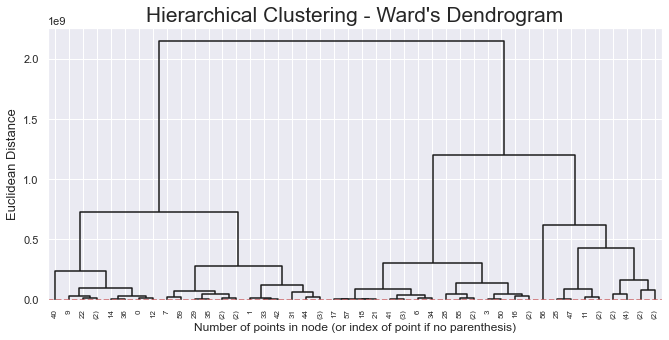

In [73]:
# Dendrogram

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hc.children_, hc.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.1825
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [74]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df_centroids1[metric])
hc4_labels

array([3, 1, 2, 2, 2, 1, 2, 1, 0, 3, 0, 0, 3, 1, 3, 1, 2, 2, 2, 1, 1, 2,
       3, 3, 0, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1, 3, 0, 0, 2, 3, 2, 1, 0,
       1, 1, 1, 0, 2, 2, 2, 3, 2, 0, 0, 2, 0, 2, 0, 1], dtype=int64)

In [75]:
df_concat1['kmeans + hierarquical'] = df_concat1['kmeans + hierarquical'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  49, 50,  51,
        52, 53,  54, 55,  56,  57,  58,  59]
                                                                  ,hc4_labels.astype(int))

In [76]:
df_concat1
#df_concat1.groupby('kmeans + hierarquical').mean()

,Point-of-Sale_ID,total_units,total_price,avg_units,avg_price,std_units,std_price,last_date,nr_days,difference,kmeans + hierarquical
0,1,435140.0,7.184216e+08,2.638971,4356.975083,2.953560,9426.485047,2019-11-01,1401,1400,2
1,2,381211.0,6.137543e+08,2.429535,3911.579922,2.925116,8992.642910,2019-11-01,1401,1400,1
2,3,577380.0,9.737919e+08,2.519297,4248.970752,3.110368,10107.390354,2019-11-01,1401,1400,0
3,4,690137.0,1.070928e+09,2.250870,3492.811978,2.420901,7180.284422,2019-11-01,1401,1400,0
4,5,469668.0,7.288484e+08,2.385700,3702.218786,2.770878,7440.028139,2019-11-01,1401,1400,2
...,...,...,...,...,...,...,...,...,...,...,...
405,406,471721.0,7.977428e+08,2.979316,5038.417955,3.733143,10736.763299,2019-11-01,1401,1400,2
406,407,611666.0,9.738926e+08,2.789162,4440.894390,3.387809,8880.066653,2019-11-01,1401,1400,2
407,408,405802.0,6.593004e+08,2.647784,4301.814375,2.892608,8510.484147,2019-11-01,1401,1400,1
408,409,432553.0,7.879761e+08,2.907607,5296.748519,3.504420,12678.868224,2019-11-01,1389,1399,2


In [135]:
#df_concat1.to_csv('Clusters_ValuePerspective_KMeansHC.csv',index=False)

In [136]:
## add column with cluster labels to the original dataset
#df_concat11=df_concat1[['Point-of-Sale_ID','kmeans + hierarquical']]
#df_concat11
#df_with_clusters=df
#df_with_clusters2=df_with_clusters.merge(df_concat11, how='left', on='Point-of-Sale_ID').rename(columns={"kmeans + hierarquical": "labels"})
#df_with_clusters2

In [166]:
## add column with cluster labels to the original dataset
df_concat11=df_concat1[['Point-of-Sale_ID','kmeans + hierarquical']]
#df_concat11
df_with_clusters=df
df_with_clusters2=df_with_clusters.merge(df_concat11, left_on='Point-of-Sale_ID', right_on='Point-of-Sale_ID') #.rename(columns={"kmeans + hierarquical": "labels"})
df_with_clusters2

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,kmeans + hierarquical
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,1
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,1
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,1
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,1
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,1
...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,1
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,1
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,1
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,1


In [34]:
#df_with_clusters2.to_csv('Big_Dataset_With_Clusters.csv',index=False)

In [168]:
# create a final dataframe with 2 columns with the clusters' labels for each perspective - preferences and value
df_with_clusters2['kmeans']=df_with_clusters3['kmeans labels']
df_with_clusters2=df_with_clusters2.rename(columns={'kmeans + hierarquical':'Value_Perspective_KM+HC', 'kmeans':'Preferences_Perspective_KM'})
df_with_clusters_finaaal=df_with_clusters2

In [169]:
df_with_clusters_finaaal

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,Point-of-Sale_ID,Date,Unit,Price,Quarter,Value_Perspective_KM+HC,Preferences_Perspective_KM
0,1,33,35,77,150,2016-12-27,1.0,495.0,2016Q4,1,0
1,1,33,313,657,150,2017-02-14,1.0,800.0,2017Q1,1,0
2,1,33,313,657,150,2017-08-24,1.0,800.0,2017Q3,1,0
3,1,33,313,657,150,2017-09-04,1.0,800.0,2017Q3,1,0
4,1,33,313,657,150,2018-10-03,1.0,750.0,2018Q4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
75980062,21,166,174,1908,403,2018-09-24,1.0,4280.0,2018Q3,1,2
75980063,21,166,174,1908,403,2019-04-22,2.0,2140.0,2019Q2,1,2
75980064,21,166,174,1908,403,2019-06-03,1.0,2095.0,2019Q2,1,2
75980065,21,166,668,122,403,2018-09-05,1.0,1850.0,2018Q3,1,2


In [170]:
#df_with_clusters_finaaal.to_csv('Big_Dataset_With_Clusters_FINAL.csv',index=False)